# 1006개의 데이터로 Transfer_Learning 하기

- 논문의 모델에 1006개의 데이터를 넣고 학습을 시켜보자
- Augmentation을 하였을 때와 하지 않았을 때의 성능의 차이를 살펴보자

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
# 모델 관련 라이브러리
from tensorflow.keras.models import load_model

import os                       # I/O 관련된 작업에 필요한 패키지 
import numpy             as np  # 데이터 array 작업에 필요한 패키지
import tensorflow        as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt # 데이터 시각화에 관련된 작업에 필요한 패키지

#### 필요한 변수들 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# BATCH_SIZE 변수
BATCH_SIZE = 32

# 이미지 사이즈 변수
IMAGE_SIZE = [1024, 1360]

# EPOCH 크기 변수
EPOCHS = 150

#### GPU 사용여부 확인

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [4]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'cellpin/CellPin')
print(ROOT_PATH)

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/mochafreddo/cellpin/CellPin
782
104
126


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'normal' in filename])
print('NORMAL images count in Train set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if 'cpe' in filename])
print('CPE images count in Train set :' + str(COUNT_CPE))

NORMAL images count in Train set :355
CPE images count in Train set :427


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in val_filenames if 'normal' in filename])
print('NORMAL images count in Validation set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if 'cpe' in filename])
print('CPE images count in Validation set :' + str(COUNT_CPE))

NORMAL images count in Validation set :50
CPE images count in Validation set :76


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in test_filenames if 'normal' in filename])
print('NORMAL images count in Test set :' + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if 'cpe' in filename])
print('CPE images count in Test set :' + str(COUNT_CPE))

NORMAL images count in Test set :40
CPE images count in Test set :64


#### tf.data 인스턴스를 만들기

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print('Train images count :' + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print('Validation images count :' + str(VAL_IMG_COUNT))

Train images count :782
Validation images count :126


#### 라벨 이름들 확인

In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/CellPin/train/*"))])
print(CLASS_NAMES)

[]


#### 라벨링 함수를 만들어 보기

In [11]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'cpe'

#### decode_img 함수와 process_path 함수를 만들기

In [12]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 1)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    if label == True:
        label = ([0, 1])
    else:
        label = ([1, 0])
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

#### train과 val에 함수들 적용해주기

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### 전처리 함수 만들기 및 적용

In [14]:
def augment(image,label):
    image = tf.image.flip_left_right(image)  # 좌우 반전
    image = tf.image.flip_up_down(image)  # 상하 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size = 1000, with_aug = False):
    
    if  with_aug:
        ds = ds.map(
            augment,  # augment 함수 적용
            num_parallel_calls = 2
            )    

    ds = ds.shuffle(buffer_size = shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds

In [15]:
train_ds_no_aug = prepare_for_training(train_ds, with_aug = False)
val_ds_no_aug = prepare_for_training(val_ds, with_aug = False)


train_ds_aug = prepare_for_training(train_ds, with_aug = True)
val_ds_aug = prepare_for_training(val_ds, with_aug = True)

#### Image shape를 변경 체크하기

In [16]:
for image, label in train_ds_no_aug.take(1):
    print('Image shape :', image.numpy().shape)
    print('Label :', label.numpy().shape)

Image shape : (32, 1024, 1360, 1)
Label : (32, 2)


In [17]:
for image, label in train_ds_aug.take(1):
    print('Image shape :', image.numpy().shape)
    print('Label :', label.numpy().shape)

Image shape : (32, 1024, 1360, 1)
Label : (32, 2)


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [18]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

104


## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

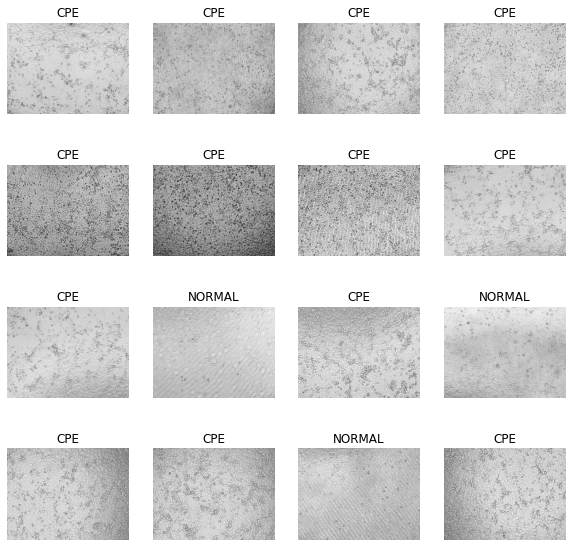

In [19]:
image_batch, label_batch = next(iter(train_ds_no_aug))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n], cmap = 'gray')
        if list(label_batch[n])[0].numpy() == 0:
            plt.title('CPE')
        else:
            plt.title('NORMAL')
        plt.axis('off')

show_batch(image_batch.numpy(), label_batch)

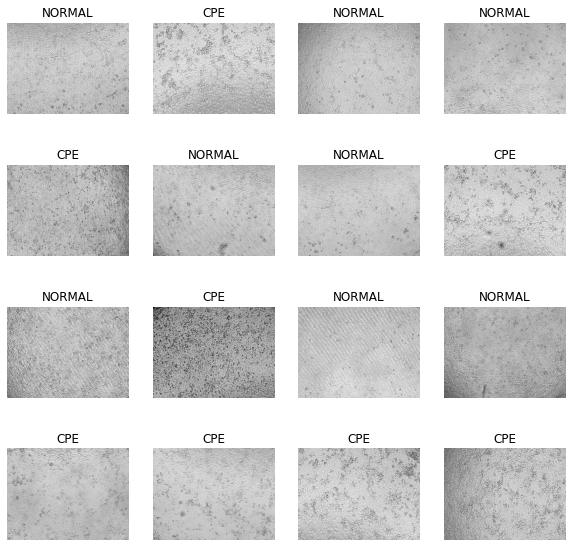

In [20]:
image_batch, label_batch = next(iter(train_ds_aug))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n], cmap = 'gray')
        if list(label_batch[n])[0].numpy() == 0:
            plt.title('CPE')
        else:
            plt.title('NORMAL')
        plt.axis('off')

show_batch(image_batch.numpy(), label_batch)

#### model building

In [21]:
no_aug_model = load_model(os.getenv('HOME') + '/cellpin/0816_influ_filter_model_1')
with_aug_model = load_model(os.getenv('HOME') + '/cellpin/0816_influ_filter_model_1')

In [22]:
no_aug_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_layer (Conv2D)    (None, 1018, 1354, 20)    1000      
_________________________________________________________________
activation_1 (Activation)    (None, 1018, 1354, 20)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 101, 135, 20)      0         
_________________________________________________________________
second_conv_layer (Conv2D)   (None, 97, 131, 25)       12525     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 131, 25)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 21, 25)        0         
_________________________________________________________________
third_conv_layer (Conv2D)    (None, 14, 19, 30)        6

In [23]:
with_aug_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv_layer (Conv2D)    (None, 1018, 1354, 20)    1000      
_________________________________________________________________
activation_1 (Activation)    (None, 1018, 1354, 20)    0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 101, 135, 20)      0         
_________________________________________________________________
second_conv_layer (Conv2D)   (None, 97, 131, 25)       12525     
_________________________________________________________________
activation_2 (Activation)    (None, 97, 131, 25)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 21, 25)        0         
_________________________________________________________________
third_conv_layer (Conv2D)    (None, 14, 19, 30)       

## Step 5. 모델 훈련

#### GPU사용하여 model complie

In [24]:
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    no_aug_model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )
     
    no_aug_check_point = tf.keras.callbacks.ModelCheckpoint('final_paper_model_no_aug_1.h5')

In [25]:
with tf.device('/GPU:0'):

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    with_aug_model.compile(
        optimizer = 'adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )
    

    with_aug_check_point = tf.keras.callbacks.ModelCheckpoint('final_paper_model_with_aug_1.h5')

#### 모델 fitting

In [26]:
with tf.device('/GPU:0'):
    history_no_aug_model = no_aug_model.fit(
        train_ds_no_aug,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds_no_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks = [no_aug_check_point]
    )

Epoch 1/150
24/24 [==============================] - 22s 491ms/step - loss: 0.8783 - accuracy: 0.5696 - precision: 0.5696 - recall: 0.5696 - val_loss: 0.7061 - val_accuracy: 0.3854 - val_precision: 0.3854 - val_recall: 0.3854
Epoch 2/150
24/24 [==============================] - 12s 525ms/step - loss: 0.7086 - accuracy: 0.5382 - precision: 0.5382 - recall: 0.5382 - val_loss: 0.6693 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 0.6250
Epoch 3/150
24/24 [==============================] - 11s 477ms/step - loss: 0.7260 - accuracy: 0.4824 - precision: 0.4824 - recall: 0.4824 - val_loss: 0.6926 - val_accuracy: 0.5833 - val_precision: 0.5833 - val_recall: 0.5833
Epoch 4/150
24/24 [==============================] - 12s 489ms/step - loss: 0.6991 - accuracy: 0.4951 - precision: 0.4951 - recall: 0.4951 - val_loss: 0.6863 - val_accuracy: 0.6146 - val_precision: 0.6146 - val_recall: 0.6146
Epoch 5/150
24/24 [==============================] - 11s 474ms/step - loss: 0.6942 - accuracy: 0

24/24 [==============================] - 11s 450ms/step - loss: 0.0985 - accuracy: 0.9713 - precision: 0.9713 - recall: 0.9713 - val_loss: 0.5335 - val_accuracy: 0.8438 - val_precision: 0.8438 - val_recall: 0.8438
Epoch 74/150
24/24 [==============================] - 11s 468ms/step - loss: 0.2074 - accuracy: 0.9240 - precision: 0.9240 - recall: 0.9240 - val_loss: 0.1982 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 75/150
24/24 [==============================] - 11s 475ms/step - loss: 0.0780 - accuracy: 0.9888 - precision: 0.9888 - recall: 0.9888 - val_loss: 0.1339 - val_accuracy: 0.9479 - val_precision: 0.9479 - val_recall: 0.9479
Epoch 76/150
24/24 [==============================] - 11s 470ms/step - loss: 0.0650 - accuracy: 0.9903 - precision: 0.9903 - recall: 0.9903 - val_loss: 0.1936 - val_accuracy: 0.9167 - val_precision: 0.9167 - val_recall: 0.9167
Epoch 77/150
24/24 [==============================] - 11s 468ms/step - loss: 0.0654 - accuracy: 0.9934 - 

Epoch 145/150
24/24 [==============================] - 11s 471ms/step - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1746 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 146/150
24/24 [==============================] - 11s 474ms/step - loss: 0.0160 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1394 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 147/150
24/24 [==============================] - 11s 472ms/step - loss: 0.0155 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1443 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 148/150
24/24 [==============================] - 11s 468ms/step - loss: 0.0156 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1861 - val_accuracy: 0.9375 - val_precision: 0.9375 - val_recall: 0.9375
Epoch 149/150
24/24 [==============================] - 11s 469ms/step - loss: 0.0153 - a

In [27]:
with tf.device('/GPU:0'):
    history_with_aug_model = with_aug_model.fit(
        train_ds_aug,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = val_ds_aug,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        callbacks = [with_aug_check_point]
    )

Epoch 1/150
24/24 [==============================] - 19s 494ms/step - loss: 0.8224 - accuracy: 0.5472 - precision: 0.5472 - recall: 0.5472 - val_loss: 0.6909 - val_accuracy: 0.5938 - val_precision: 0.5938 - val_recall: 0.5938
Epoch 2/150
24/24 [==============================] - 11s 473ms/step - loss: 0.7116 - accuracy: 0.5162 - precision: 0.5162 - recall: 0.5162 - val_loss: 0.6773 - val_accuracy: 0.6146 - val_precision: 0.6146 - val_recall: 0.6146
Epoch 3/150
24/24 [==============================] - 11s 471ms/step - loss: 0.7088 - accuracy: 0.5088 - precision: 0.5088 - recall: 0.5088 - val_loss: 0.6906 - val_accuracy: 0.5833 - val_precision: 0.5833 - val_recall: 0.5833
Epoch 4/150
24/24 [==============================] - 11s 471ms/step - loss: 0.7055 - accuracy: 0.4976 - precision: 0.4976 - recall: 0.4976 - val_loss: 0.7839 - val_accuracy: 0.3854 - val_precision: 0.3854 - val_recall: 0.3854
Epoch 5/150
24/24 [==============================] - 11s 474ms/step - loss: 0.7128 - accuracy: 0

24/24 [==============================] - 11s 467ms/step - loss: 0.0345 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3345 - val_accuracy: 0.8854 - val_precision: 0.8854 - val_recall: 0.8854
Epoch 74/150
24/24 [==============================] - 11s 458ms/step - loss: 0.0357 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3323 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 75/150
24/24 [==============================] - 11s 477ms/step - loss: 0.0342 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9965 - val_loss: 0.3292 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 76/150
24/24 [==============================] - 11s 454ms/step - loss: 0.0330 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3363 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 77/150
24/24 [==============================] - 11s 474ms/step - loss: 0.0330 - accuracy: 1.0000 - 

Epoch 145/150
24/24 [==============================] - 11s 481ms/step - loss: 0.0216 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - val_loss: 0.3845 - val_accuracy: 0.8958 - val_precision: 0.8958 - val_recall: 0.8958
Epoch 146/150
24/24 [==============================] - 11s 455ms/step - loss: 0.0129 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2621 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 147/150
24/24 [==============================] - 11s 472ms/step - loss: 0.0113 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3806 - val_accuracy: 0.9062 - val_precision: 0.9062 - val_recall: 0.9062
Epoch 148/150
24/24 [==============================] - 11s 478ms/step - loss: 0.0102 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3746 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 149/150
24/24 [==============================] - 11s 476ms/step - loss: 0.0102 - a

## Step 6. 결과 확인 및 시각화

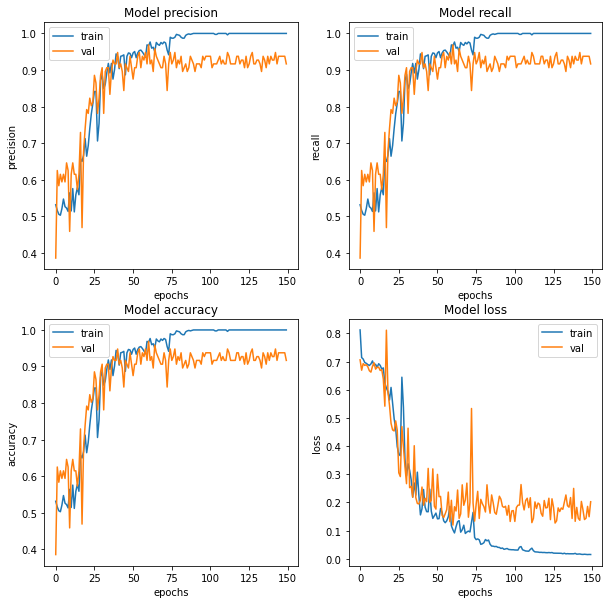

In [28]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_aug_model.history[met])
    ax[i].plot(history_no_aug_model.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

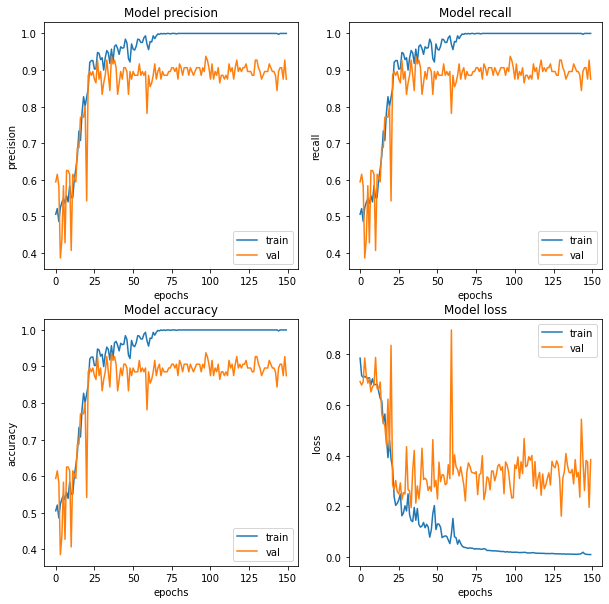

In [29]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_with_aug_model.history[met])
    ax[i].plot(history_with_aug_model.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Step 7. 최종 Test dataset 검정하기

In [30]:
no_aug_model = tf.keras.models.load_model('final_paper_model_no_aug_1.h5')
loss, acc, prec, rec = no_aug_model.evaluate(test_ds)

4/4 [==============================] - 1s 96ms/step - loss: 0.0840 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712


In [31]:
with_aug_model = tf.keras.models.load_model('final_paper_model_with_aug_1.h5')
loss, acc, prec, rec = with_aug_model.evaluate(test_ds)

4/4 [==============================] - 1s 80ms/step - loss: 0.3003 - accuracy: 0.9327 - precision: 0.9327 - recall: 0.9327


## Discussion